# Creation of Black Litterman model

note: PyPortfolioOpt package requires Python 3.9 and below due to qdldl dependencies in Python 3.11

In [1]:
# install required packages
# git clone: 3rd party PyPortfolioOpt package

!pip3 install pandas numpy matplotlib yfinance PyPortfolioOpt
!pip3 install pandas-datareader
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yf
import pypfopt

/Users/estherwee/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
tickers = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-03-31'
end_date = '2023-10-20'

In [4]:
merged = pd.read_excel("merged.xlsx", index_col=0)
pred = pd.read_excel("predictions.xlsx", index_col=0)

# stock price cannot be negative
pred.mask(pred < 0, 0, inplace=True)

In [5]:
# truncate first 60 rows, insufficent data to predict

pred = pred[60:]
merged = merged[60:]

In [6]:
# set index of predicted adj close to date
DateList = merged.index.to_list()
pred["Date"] = DateList
pred.set_index("Date", inplace = True)

# drop '2010-05-19' (Saturday): non-trading day
pred = pred.drop('2010-05-19')
merged = merged.drop('2010-05-19')

In [7]:
stockList = []
for stock in tickers:
    stockList.append(f"{stock}_Adj Close")

prices = merged[stockList]
prices.columns = prices.columns.str.replace("_Adj Close", "")


In [8]:
#SP500 ETF Benchmark
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices

[*********************100%%**********************]  1 of 1 completed


Date
2010-03-31     90.688110
2010-04-01     91.308205
2010-04-05     92.052338
2010-04-06     92.269356
2010-04-07     91.742271
                 ...    
2023-10-13    431.500000
2023-10-16    436.040009
2023-10-17    436.019989
2023-10-18    430.209991
2023-10-19    426.429993
Name: Adj Close, Length: 3413, dtype: float64

In [9]:
# mcaps = {}
# for t in tickers:
#     stock = yf.Ticker(t)
#     mcaps[t] = stock.info["marketCap"]
# mcaps

# this should return a dictionary of marketcaps of our 5 stocks
# however, YFinance returned error 404 due to technical issues
# hence, we will manually pull the market cap from yfinance

# tickers = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

mcaps = {
    'AAPL': 2.76 * 1000000000000,
    'NVDA': 1.112 * 1000000000000,
    'MAR': 57.053 * 1000000000,
    'LMT': 113.639 * 1000000000,
    'BA': 118.001 * 1000000000
}

In [10]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
     

3.6020678699989643

In [11]:
# inital expected returns not affected by market sentiment
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.428225
NVDA    0.446357
MAR     0.233701
LMT     0.153651
BA      0.371138
dtype: float64

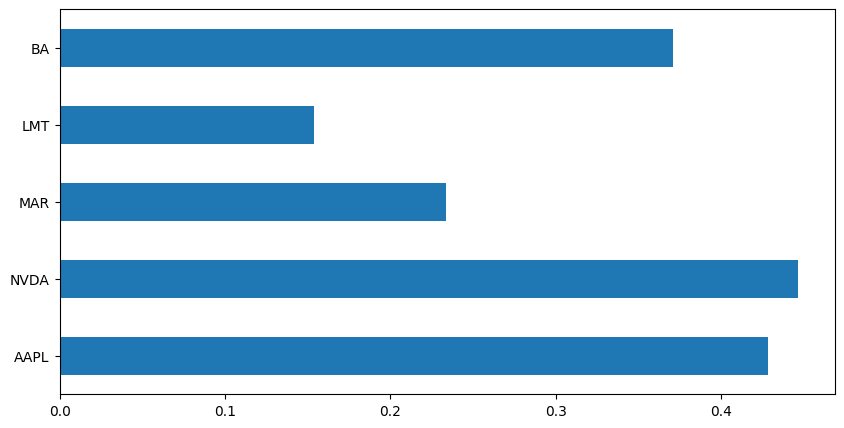

In [12]:
market_prior.plot.barh(figsize=(10,5));

In [13]:
tickers = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# create a dictionary of magnitude of views and map to relevant stock
confidence = []
for ticker in tickers:
    confidencel_level = (pred[f'{ticker}'].iloc[-1] - prices[f'{ticker}'].iloc[-1])/ prices[f'{ticker}'].iloc[-1]
    confidence.append(confidencel_level)

viewdict = {}
for i in range(5):
    viewdict[tickers[i]] = confidence[i]

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

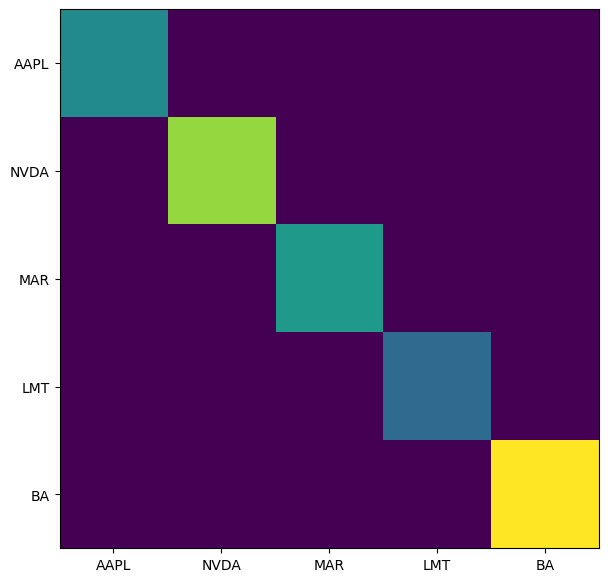

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
# set omega to uncertainty matrix
omega = bl.omega

In [16]:
# compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=viewdict, omega=omega)

In [17]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.141905
NVDA    0.117765
MAR     0.009882
LMT     0.002511
BA      0.050018
dtype: float64

In [18]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.428225,0.141905,-0.027481
NVDA,0.446357,0.117765,-0.029242
MAR,0.233701,0.009882,-0.049147
LMT,0.153651,0.002511,-0.036197
BA,0.371138,0.050018,-0.006733


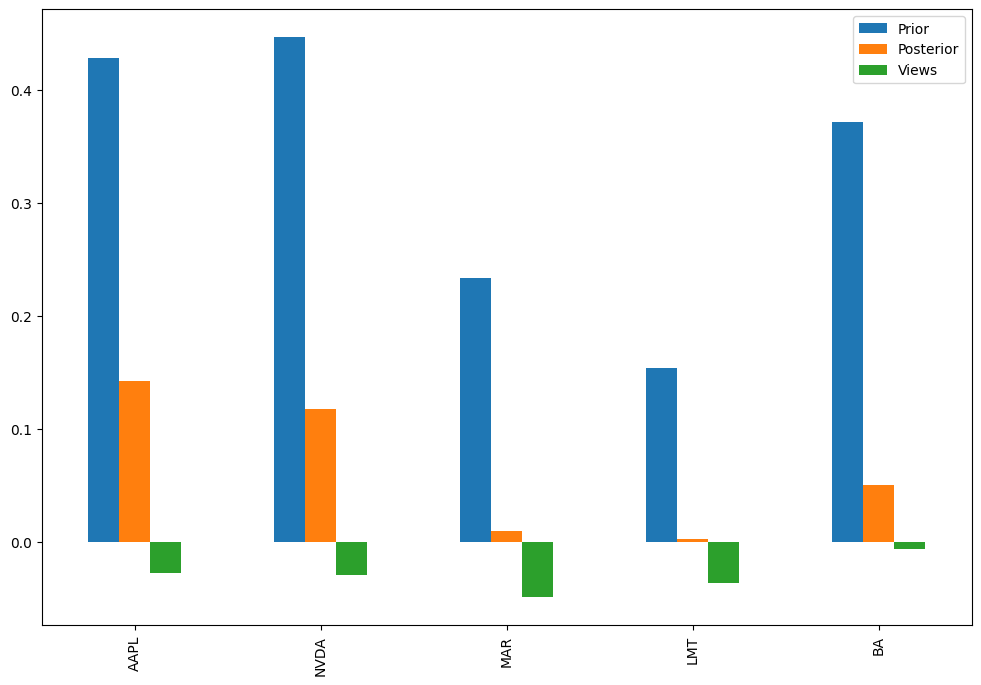

In [19]:
rets_df.plot.bar(figsize=(12,8));

In [20]:
S_bl = bl.bl_cov()
S_bl

,AAPL,NVDA,MAR,LMT,BA
AAPL,0.137411,0.076308,0.051903,0.032467,0.085322
NVDA,0.076308,0.240861,0.072095,0.040289,0.113918
MAR,0.051903,0.072095,0.155382,0.035055,0.107813
LMT,0.032467,0.040289,0.035055,0.100741,0.066549
BA,0.085322,0.113918,0.107813,0.066549,0.286345


In [21]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()

/Users/estherwee/Library/Python/3.9/lib/python/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.5538309056520455),
             ('NVDA', 0.3902666329520738),
             ('MAR', 0.0),
             ('LMT', 0.0),
             ('BA', 0.0559024613958807)])

In [22]:
weights = ef.clean_weights()
weights


OrderedDict([('AAPL', 0.55383),
             ('NVDA', 0.39027),
             ('MAR', 0.0),
             ('LMT', 0.0),
             ('BA', 0.0559)])

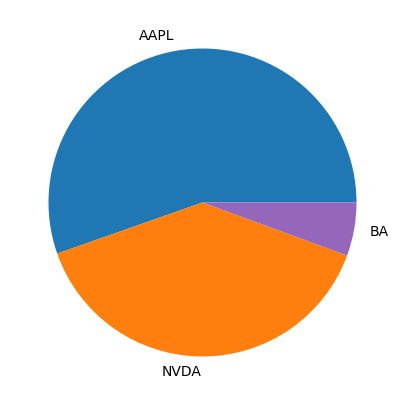

In [23]:
pd.Series(weights).plot.pie(figsize=(5,5));

# Calculating Sharpe Ratio

In [24]:
# S_bl: cov matrix
weights_numpy = np.array(
     [[ 0.55383],
      [ 0.39027],
      [ 0],
      [ 0],
      [ 0.0559]])

In [25]:
portfolio_risk = np.dot(weights_numpy.T,np.dot(S_bl,weights_numpy))[0][0]

portfolio_risk

0.12296851371542356

In [26]:
ret = ret_bl.tolist()
# value = 1
# ret = [i + value for i in ret]

weights = list(weights.items())

weightsList = []
for weight in weights:
    stock, returns = weight
    weightsList.append(returns)

result = [a * b for a, b in zip(ret, weightsList)]
portfolio_return = sum(result)

# risk free rate: 2023-10-19 
risk_free_rate = 0.0498


In [27]:
portfolio_return

0.1273475051243113

In [28]:
sharpe_ratio = (portfolio_return - risk_free_rate)/portfolio_risk
print(sharpe_ratio)

# portfolio_risk

0.6306289535528864
